https://github.com/Kabanosk/whisper-website
https://github.com/openai/whisper/discussions/264

In [ ]:
# %%capture
# %pip install python-dotenv

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import yt_dlp
import unzip
from typing import List, Callable, Optional, Dict

# increase column width
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', None)

# Download Audio and Transcribe

In [2]:
VIDEO_URL = "https://youtu.be/DgTjSrrf6GQ"
AUDIO_FILE_NAME = "./data/audio/Lex_Podcast.mp3"
AUDIO_QUALITY = 5 # 0 best - 10 worst (default 5)
AUDIO_FORMAT = "mp3"
FFMPEG_LOCATION = "ffmpeg-master-latest-win64-gpl/bin"
SUBTITLE_LANGUAGE = "en.*"
TRANSCRIPT_FILE_NAME = "./data/transcript.txt"
SUBTITLE_FORMAT = "srt"

In [ ]:
import wget
import os
import zipfile

FFMPEG_URL = 'https://github.com/yt-dlp/FFmpeg-Builds/releases/download/latest/ffmpeg-master-latest-win64-gpl.zip'
ZIP_PATH = './ffmpeg.zip'
EXTRACT_DIR = './'

if not os.path.exists(ZIP_PATH):
    print('Downloading ffmpeg...')
    wget.download(FFMPEG_URL, ZIP_PATH)

    print('Unzipping...') 
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    
    print('Removing zip file...')
    os.remove(ZIP_PATH)

else:
    print('Already downloaded.')

In [ ]:
!yt-dlp -xv --ffmpeg-location ffmpeg-master-latest-win64-gpl/bin --audio-format mp3  -o data/audio/Lex_Podcast -- {"https://youtu.be/DEu24V8vfb8"}
#!yt-dlp -xv --ffmpeg-location {FFMPEG_LOCATION} --audio-format {AUDIO_FORMAT}  -o {AUDIO_FILE_NAME} -- {"https://youtu.be/DEu24V8vfb8"}

In [ ]:
import openai
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())  # add .env to .gitignore
openai.api_key = os.getenv("OPENAI_API_KEY")


In [ ]:
audio_file = open("data/audio/Lexicap.mp3", "rb")
transcript = openai.Audio.transcribe("whisper-1", audio_file, response_format=SUBTITLE_FORMAT)

In [ ]:
# with open("langchain.srt", "w") as f:
#     f.write(transcript)

## Longer Inputs
By default, the Whisper API only supports files that are less than 25 MB. If you have an audio file that is longer than that, you will need to break it up into chunks of 25 MB's or less or used a compressed audio format. To get the best performance, we suggest that you avoid breaking the audio up mid-sentence as this may cause some context to be lost.

One way to handle this is to use the [PyDub open source Python package](https://github.com/jiaaro/pydub) to split the audio:

In [ ]:
from pydub import AudioSegment

song = AudioSegment.from_mp3("good_morning.mp3")

# PyDub handles time in milliseconds
ten_minutes = 10 * 60 * 1000

first_10_minutes = song[:ten_minutes]

first_10_minutes.export("good_morning_10.mp3", format="mp3")

### Prompting
* Check out [OpenAI](https://platform.openai.com/docs/guides/speech-to-text/prompting)

# Download Transcript

In [ ]:
# Download the transcript with yt-dlp
!yt-dlp --write-auto-sub --skip-download --sub-format {SUBTITLE_FORMAT} --sub-lang {SUBTITLE_LANGUAGE} --output {TRANSCRIPT_FILE_NAME} -- {VIDEO_URL}

## Data Preparation
Let's change the name of the raw caption files:

In [ ]:
# Get a clean list of podcast titles
import re 

def clean_titles(title):
    title = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1', title)
    title = re.sub(r'\|.*?\d+', '', title)
    title = title.rstrip().replace(' ', '_').replace(':', '_').replace('&','and').lower()
    title = re.sub(r'[^a-zA-Z0-9_]', '', title)
    return title

with open('./data/Lexicap.md', 'r') as f:
    text = f.read()

titles = text.split('\n')
titles = [clean_titles(title) for title in titles if title != '']

In [ ]:
# Rename the transcript files
import os

TRANSCRIPT_PATH = "./data/transcripts/"
FILE_EXTENSION = '.vtt'

for org_filename, line_idx in zip(os.listdir(path=TRANSCRIPT_PATH), titles):
    if org_filename.endswith(FILE_EXTENSION):
        print(org_filename)
        # rename file 
        new_filename = f"{line_idx}{FILE_EXTENSION}"
        os.rename(f"{TRANSCRIPT_PATH}{org_filename}", f"{TRANSCRIPT_PATH}{new_filename}")

# Start
### Data Cleaning

In [3]:
TRANSCRIPT_PATH = "./data/transcripts/"
FILE_EXTENSION = '.vtt'

In [4]:
# Create new transcript file with timestamp and text
TRANSCRIPT_FILE_NAME = "45_michio_kaku__future_of_humans_aliens_space_travel_and_physics.vtt"
NEW_TRANSCRIPT_FILE_NAME = "45_michio_kaku__future_of_humans_aliens_space_travel_and_physics.csv"


with open(f"{TRANSCRIPT_PATH}{TRANSCRIPT_FILE_NAME}") as oldfile, open(f"{NEW_TRANSCRIPT_FILE_NAME}", 'w') as newfile:
    old_lines = oldfile.read().split('\n')
    clean_lines = [line for line in old_lines if line not in ['', 'WEBVTT']]

    for line_idx in range(0, len(clean_lines)-1, 2):
         timestamp = clean_lines[line_idx].split('-->')[0].strip()
         # Standardize timestamp format
         timestamp = "00:" + timestamp if len(timestamp.split(':')) < 3 else timestamp
         timestamp = "0" + timestamp if len(timestamp.split(':')[0]) < 2 else timestamp
         text = clean_lines[line_idx+1].rstrip()
         new_line = f"{timestamp};{text}\n"
         newfile.write(new_line)


In [5]:
df = pd.read_csv(f"{NEW_TRANSCRIPT_FILE_NAME}"
                            ,sep=';', 
                            header=None, names=['timestamp', 'text'],)
df.head(25)

,timestamp,text
0,00:00:00.000,The following is a conversation with Michio Kaku.
1,00:00:02.800,"He's a theoretical physicist, futurist,"
2,00:00:05.120,and professor at the City College of New York.
3,00:00:08.360,He's the author of many fascinating books
4,00:00:10.760,that explore the nature of our reality
5,00:00:12.840,and the future of our civilization.
6,00:00:15.520,"They include Einstein's Cosmos, Physics of the Impossible,"
7,00:00:19.200,"Future of the Mind, Parallel Worlds,"
8,00:00:21.600,"and his latest, The Future of Humanity,"
9,00:00:24.240,"Terraforming Mars Interstellar Travel,"


* Ideas
* Summarization of main topics in the audio
* Go to the mentions of the topics
* translation to arabic
* The app ask me questions about the text (for language learning) and create a discussion
* Click on named-entity, book in order to play at timestamp
* Webapp or Mobile app

* Since Whisper has not skipped the punctuations in the transcript, we can reconstruct full sentences, ensuring that each sentence is ended with a period `.`

In [6]:
# Recreate the dataframe with full sentences
transcript_df = pd.DataFrame(columns=df.columns)

for idx, timestamp, text in df.itertuples():
    while text[-1] != '.':
        idx += 1
        text += df.loc[idx]['text']
    transcript_df = pd.concat([transcript_df, pd.DataFrame({'timestamp': timestamp, 'text': text}, index=[0])], ignore_index=True)

# Remove any piece of text if it is included in previous text
not_part_of_previous = [True]
for i in range(1, len(transcript_df)):
    not_part_of_previous.append(transcript_df['text'][i] not in transcript_df['text'][i-1])
transcript_df = transcript_df[not_part_of_previous] 


# 1. NER
* Add column for persons, orginazations, books, companies, countries, places.

## Mentioned Books

In [8]:
#%%capture
# %pip install -U spaCy
# %pip install 'spacy[transformers]'
#!python -m spacy download en_core_web_trf # download best-matching version of specific model

In [9]:
import spacy
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_trf", disable=["tok2vec","parser"]) #disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"]

# check processing pipeline components of nlp object
nlp.pipeline


[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x21f879674c0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x21f879665c0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x21f87905700>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x21f87988240>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x21f879595b0>)]

In [10]:
# create a Doc by processing a string of text with the nlp object
doc = nlp("So I'm with Jared Diamond, you know, in the book Collapse, \
          where he points out studying the collapse of major civilizations, \
          that it often happens right after things appear to never have been better. Hmm.")


# iterate over tokens in a Doc
print("Entities: ", [e.text for e in doc.ents if e.label_ == 'WORK_OF_ART'])


Entities:  ['Collapse']


In [11]:
# Find book related sentences in the transcript
book_related_phrases = [
    "book", "books", "i read", 
    "everyone should read", "you should read", "he wrote a novel",
    "i recommend", "highly recommend", "you must read", 
    "shouldn't miss", "top books", "best books", 
    "favorite book", "my favorite books", "book you need to read",
    "books to read before", "essential books", "great book for",
    "worthy read", "book of the year", "award winning book"
]




def contains_book_phrase(text: str, search_list: List[str]) -> bool:
    """
    Check if a text contains any of a list of book-related phrases.

    :param text: The text to search within.
    :param search_list: A list of phrases to search for.
    :return: True if any phrase is found in the text, False otherwise.
    """
    return any(phrase in text.lower() for phrase in search_list)


transcript_df["is_book_related"] = transcript_df["text"].apply(contains_book_phrase, search_list=book_related_phrases)

In [12]:
def get_book_titles_candidates(text: str, pipeline: Callable[[str], 'Doc']) -> List[str]:
    """
    Extract potential book titles from a text using a given NLP model.

    :param text: The text to extract titles from.
    :param pipeline: The NLP model to use for text processing.
    :return: A list of potential book titles.
    """
    doc = nlp(text)
    book_titles_candidates = [entity.text for entity in doc.ents if entity.label_ == 'WORK_OF_ART']
    return book_titles_candidates


In [13]:
transcript_df.query("is_book_related == True")["text"].apply(get_book_titles_candidates,
                                                                  pipeline=nlp)

3                               []
182                             []
341                             []
478       [The Future of the Mind]
638                             []
859                             []
940                             []
954     [The Theory of Everything]
957                             []
1149          [Future of Humanity]
Name: text, dtype: object

In [14]:
# Add book candidates to the dataframe
transcript_df["book_candidates"] = transcript_df.apply(lambda x: get_book_titles_candidates(x["text"], pipeline=nlp) \
                                                                 if x["is_book_related"] else [], axis=1)

In [15]:
transcript_df.query("is_book_related == True")

,timestamp,text,is_book_related,book_candidates
3,00:00:08.360,He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.,True,[]
182,00:08:30.920,"And Stephen Hawking, for example, even in his last book, even said that this is an argument against the existence of God.",True,[]
341,00:16:04.760,"If you read the book, the aliens did not have evil intentions toward homo sapiens.",True,[]
478,00:22:38.600,"I have a book, The Future of the Mind, where I detail some of these breakthroughs.",True,[The Future of the Mind]
638,00:29:54.080,"Our ancestors were lucky if they had one line, just one line in a church book, saying the date they were baptized and the date they died.",True,[]
859,00:40:07.240,"For Isidor Rabi, it was a book about the planets.",True,[]
940,00:44:06.200,"That desk had a book on it, which was opened.",True,[]
954,00:44:43.160,"And then over the years, I found out the guy had a name, Albert Einstein, and that book was The Theory of Everything.",True,[The Theory of Everything]
957,00:44:53.080,"Well, today I can read that book.",True,[]
1149,00:53:36.600,"And in my book, Future of Humanity, I even speculate beyond that, that by the end of this century, we'll probably have the first starships.",True,[Future of Humanity]


In [16]:
import requests

def get_book_info(title: str) -> Optional[Dict]:
    """
    Fetch book information from Google Books API.

    :param title: The title of the book to search for.
    :return: A dictionary containing book information if found, None otherwise.
    """
    try:
        response = requests.get(f"https://www.googleapis.com/books/v1/volumes?q={title}")

        # Raise an exception if the request was unsuccessful
        response.raise_for_status()

    except requests.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
        return None
    except Exception as err:
        print(f'Other error occurred: {err}')
        return None

    else:
        data = response.json()
        most_rated_book = None
        # Find popular book (highest ratings count)
        max_ratings_count = -1
        for book in data["items"]:
            ratings_count = book["volumeInfo"].get("ratingsCount", 0)
            if ratings_count > max_ratings_count:
                max_ratings_count = ratings_count
                most_rated_book = book

    return most_rated_book["volumeInfo"]


get_book_info("Parallel Worlds")


{'title': 'Parallel Worlds',
 'subtitle': 'A Journey Through Creation, Higher Dimensions, and the Future of the Cosmos',
 'authors': ['Michio Kaku'],
 'publisher': 'Anchor',
 'publishedDate': '2006-02-14',
 'description': 'Sheds new light on discoveries that have revolutionized the field of cosmology and transformed understanding of the universe, offering an explanation of the multiverse M-theory and its implications in terms of the fate of our own universe.',
 'industryIdentifiers': [{'type': 'OTHER', 'identifier': 'UVA:X004898840'}],
 'readingModes': {'text': False, 'image': False},
 'pageCount': 452,
 'printType': 'BOOK',
 'categories': ['Science'],
 'averageRating': 3.5,
 'ratingsCount': 11,
 'maturityRating': 'NOT_MATURE',
 'allowAnonLogging': False,
 'contentVersion': '0.2.1.0.preview.0',
 'panelizationSummary': {'containsEpubBubbles': False,
  'containsImageBubbles': False},
 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=21NGAAAAYAAJ&printsec=frontco

## Identify Other Entities

In [17]:
# %%capture
# %pip install textacy

In [18]:
import textacy

entity_types = ['PERSON', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'NORP', 'WORK_OF_ART', 'LAW']

from typing import List, Optional, Union
from spacy.tokens import Doc

def extract_entities(doc: Doc, 
                     include_types: Optional[Union[str, List[str]]] = None, 
                     sep: str = ' ') -> List[str]:
    """
    Extract named entities from a document and return them as strings.

    :param doc: The document to extract entities from.
    :param include_types: The types of entities to include. If None, include all types.
    :param sep: The separator to use when joining lemmas of multi-token entities.
    :return: A list of named entities in the form 'lemma/label'.
    """
    ents = textacy.extract.entities(doc, 
                                    include_types=include_types, 
                                    exclude_types=None, 
                                    drop_determiners=True, 
                                    min_freq=1)
    
    return [sep.join([token.text for token in entity])+'/'+entity.label_ for entity in ents]

* When processing large volumes of text, it is recommended to use spaCys batch processing for a significant performance gain. The function `nlp.pipeline` takes an iterable of texts, processes them internally as batch, and yields a list fo processed Doc objects in the same order as the input data.
* To use `nlp.pipeline`, we first have to define a batch size. Then we can loop over the batches and call `nlp.pipe`. In the inner loop we extract the features from the processed doc and write the values back into the a list:

In [19]:
# Extract entities from the transcript
import numpy as np
from tqdm import tqdm

batch_size = 50
batches = np.ceil(len(transcript_df) / batch_size).astype(int)

named_entities = []

# loop over batches, step size is equal to batch size
for i in tqdm(range(0, len(transcript_df), batch_size), total=batches):
    docs = nlp.pipe(transcript_df['text'][i:i+batch_size])
    
    for doc in docs:
        named_entities.append(extract_entities(doc, include_types=entity_types)) 

transcript_df['named_entities'] = named_entities 

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


In [20]:
# Add columns for each entity type
for ent_type in entity_types:
    transcript_df[ent_type.lower()] = transcript_df["named_entities"].apply(lambda x: \
                                                                            [entity.split('/')[0] for entity in x if entity.split('/')[1] == ent_type])

In [21]:
transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,person,org,gpe,loc,product,event,norp,work_of_art,law
0,00:00:00.000,The following is a conversation with Michio Kaku.,False,[],[Michio Kaku/PERSON],[Michio Kaku],[],[],[],[],[],[],[],[]
1,00:00:02.800,"He's a theoretical physicist, futurist, and professor at the City College of New York.",False,[],[City College of New York/ORG],[],[City College of New York],[],[],[],[],[],[],[]


In [22]:
def contains_empty_list(df: pd.DataFrame, col_name: str) -> bool:
    """
    Check if a column in a DataFrame contains any empty lists.

    :param df: The DataFrame to check.
    :param col_name: The name of the column to check.
    :return: True if any empty list is found, False otherwise.
    """
    return df[col_name].apply(lambda x: x == []).any()


# Find columns with empty lists
cols_to_clean = [col for col in transcript_df.columns if contains_empty_list(transcript_df, col)]

# Remove empty lists 
for ent_type in cols_to_clean:
    transcript_df[ent_type] = transcript_df[ent_type].apply(lambda x: x if len(x) > 0 else None)

In [23]:
from collections import Counter 
import pandas as pd
from typing import Optional, Callable

def count_words(dataframe: pd.DataFrame, 
                column: str, 
                preprocess: Optional[Callable[[str], str]] = None, 
                min_frequency: int = 1) -> pd.DataFrame:
    """
    Count words in a specific column of a DataFrame.

    :param dataframe: The DataFrame to count words from.
    :param column: The column to count words in. Should be tokenized.
    :param preprocess: An optional function to preprocess the words before counting.
    :param min_frequency: The minimum frequency for a word to be included in the output.
    :return: A DataFrame sorted by word frequency, containing words and their frequencies.
    """
    word_counter = Counter()

    # If a preprocessing function is provided, apply it before counting words
    if preprocess:
        dataframe[column].map(lambda doc: word_counter.update(preprocess(doc)))
    else:
        dataframe[column].map(word_counter.update)

    # Convert Counter to DataFrame
    word_freq_df = pd.DataFrame.from_dict(word_counter, orient='index', columns=['freq'])
    
    # Filter words by minimum frequency
    word_freq_df = word_freq_df.query('freq >= @min_frequency')
    
    # Set index name for the dataframe
    word_freq_df.index.name = column

    # Sort DataFrame by frequency
    return word_freq_df.sort_values('freq', ascending=False)


In [24]:
# %%capture
# %pip install WordCloud

In [25]:
from wordcloud import WordCloud 
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def generate_word_cloud(data: pd.DataFrame,
                        col_name: str, 
                        max_words: int = 200) -> None:
    """
    Generate a word cloud from word frequencies.

    :param data: A pandas DataFrame containing text data.
    :param col_name: The column name to count words from.
    :param max_words: The maximum number of words in the word cloud.
    """
    word_frequencies = count_words(data, col_name).freq

    # Convert pandas Series to Counter object
    word_frequencies = Counter(word_frequencies.fillna(0).to_dict())

    # Create wordcloud object
    word_cloud = WordCloud(width=800, height=400, 
                           background_color= "black", colormap="Paired", 
                           max_font_size=150, max_words=max_words)

    # Generate word cloud image from frequencies
    word_cloud.generate_from_frequencies(word_frequencies)

    # Display the cloud using matplotlib 
    plt.title(col_name.capitalize()) 
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")


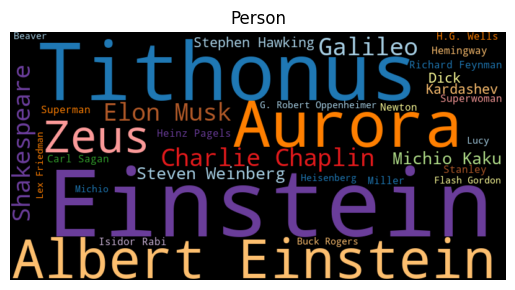

In [26]:
generate_word_cloud(transcript_df, 'person')

In [27]:
transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,person,org,gpe,loc,product,event,norp,work_of_art,law
0,00:00:00.000,The following is a conversation with Michio Kaku.,False,None,[Michio Kaku/PERSON],[Michio Kaku],None,None,None,None,None,None,None,None
1,00:00:02.800,"He's a theoretical physicist, futurist, and professor at the City College of New York.",False,None,[City College of New York/ORG],None,[City College of New York],None,None,None,None,None,None,None


# Q&A
## Prepare the data:

I have to reconstruct the dataframe to get longer text to be more useful in vectore store.

In [28]:
transcript_df['group'] = transcript_df.index // 20
grouped_transcript_df = transcript_df.groupby('group').agg({
    'timestamp': 'first',
    'text': ' '.join,
    'is_book_related': 'any',
    'book_candidates': 'sum',
    'named_entities': 'sum',
    
})

I will add a new column with that contains identified named-entities in plain text. First, let's create a column with entity dict:

In [29]:
def entities_to_dict(entities):
    """
    This function takes a list of entities in the format "entity/ENTITY_TYPE" and returns a dictionary
    where the keys are entity types and the values are lists of entities of that type.

    Parameters:
    entities (list): The input list of entity strings to be processed. Each entity string should be in the format
                     "entity/ENTITY_TYPE". 

    Returns:
    dict: A dictionary where the keys are descriptions of entity types (as strings), and the values are lists of 
          entities (as strings) of the corresponding type. If the input is not a list, returns an empty dictionary.
    """

    # # Define a mapping from entity types to their descriptions
    # entity_type_mapping = {
    #     'PERSON': 'People, including fictional',
    #     'NORP': 'Nationalities or religious or political groups',
    #     'ORG': 'Companies, agencies, and institutions',
    #     'GPE': 'Countries, cities, and states',
    #     'LOC': 'Non-GPE locations, mountain ranges, bodies of water',
    #     'PRODUCT': 'Objects, vehicles, foods, etc. (Not services)',
    #     'EVENT': 'Named hurricanes, battles, wars, sports events, etc',
    #     'WORK_OF_ART': 'Titles of books, songs, etc',
    #     'LAW': 'Named documents made into laws',
    # }


    if not isinstance(entities, list):
        return {}

    entities_by_type = {}
    for entity in entities:
        name, entity_type = entity.split('/')
        # Use the mapping to change the keys
        #entity_type = entity_type_mapping.get(entity_type, entity_type)
        if entity_type not in entities_by_type:
            entities_by_type[entity_type] = []
        entities_by_type[entity_type].append(name)
    return entities_by_type


In [30]:
# Apply the helper function
grouped_transcript_df['named_entities_dict'] = grouped_transcript_df['named_entities'].apply(entities_to_dict)

In [31]:
grouped_transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,named_entities_dict
group,,,,,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding. That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.",True,0,"[Michio Kaku/PERSON, City College of New York/ORG, Einstein/PERSON, Cosmos/WORK_OF_ART, Physics of the Impossible/WORK_OF_ART, Future of the Mind/WORK_OF_ART, Parallel Worlds/WORK_OF_ART, Future of Humanity/WORK_OF_ART, Terraforming Mars Interstellar Travel/WORK_OF_ART]","{'PERSON': ['Michio Kaku', 'Einstein'], 'ORG': ['City College of New York'], 'WORK_OF_ART': ['Cosmos', 'Physics of the Impossible', 'Future of the Mind', 'Parallel Worlds', 'Future of Humanity', 'Terraforming Mars Interstellar Travel']}"
1,00:00:56.640,"This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course. Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them.",False,0,"[Artificial Intelligence Podcast/ORG, YouTube/ORG, iTunes/ORG, Lex Friedman/PERSON, Michio Kaku/PERSON, Milky Way/LOC, Earth/LOC]","{'ORG': ['Artificial Intelligence Podcast', 'YouTube', 'iTunes'], 'PERSON': ['Lex Friedman', 'Michio Kaku'], 'LOC': ['Milky Way', 'Earth']}"


In [32]:
# Convert list to string separated by commas
def list_to_str(lst):
    """
    This function takes a list of strings and converts it into a single string, with elements separated by commas.

    Parameters:
    lst (list or str): The input list or string to be formatted.

    Returns:
    str: The formatted string if the input is a list of strings, otherwise the input itself.
    """
    if isinstance(lst, list):
        if len(lst) > 1:
            return ', '.join(lst[:-1]) + ', and ' + lst[-1]
        elif lst:
            return lst[0]
    return lst

# Then generate the new 'named_entities' column
def entities_plain_txt(row):
    """
    Converts a dictionary of entity types and entities into a plain text.

    Parameters:
    row (dict): Dictionary where keys are entity types and values are lists of entities.

    Returns:
    str: A formatted string that lists each entity type and its entities.
    """
    output = ""
    for entity_type, entities in row.items():
        entities_str = list_to_str(entities)
        output += f'{entity_type.title()}: {entities_str}\n'
    return output

In [33]:
grouped_transcript_df['named_entities'] = grouped_transcript_df['named_entities_dict'].apply(entities_plain_txt)

In [34]:
# Concatenate text, named entities, and book candidates into a single column
final_text = grouped_transcript_df.apply(lambda row: f"{row['text']}\n\n" \
                                            f"{row['named_entities']}\n\n", axis=1)
                                            #f"# Does the script contain books related conten:\n{str(row['is_book_related'])}\n\n" \
                                            #f"# Books mentioned in the script:\n{str(row['book_candidates'])}"
# creating the new DataFrame
df_final = pd.DataFrame({
    'timestamp': grouped_transcript_df['timestamp'],
    'text': final_text
})

In [35]:
df_final.head(2)

,timestamp,text
group,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding. That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.\n\nPerson: Michio Kaku, and Einstein\nOrg: City College of New York\nWork_Of_Art: Cosmos, Physics of th..."
1,00:00:56.640,"This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course. Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them.\n\nOrg: Artificial Intelligence Podcast, YouTube, and iTunes\nPerson: Lex Friedman, and Michio Kaku\nLoc: Milky Way, and Earth\n\n\n"


In [36]:
df_final.to_csv('data\michio_kaku_transcript.csv', index=False)

## Quesion answering with LangChain 
Question answering over documents consists of four steps:

1. Create an index : There are three main steps going on after the documents are loaded:
    * Splitting documents into chunks (here is not necessary because the documents/text is not too long)
    * Creating embeddings for each document
    * Storing documents and embeddings in a vectorstore



2. Create a Retriever from that index
3. Create a question answering chain

4. Ask questions!
---
* See also: 
    * [LangChain Documentation](https://python.langchain.com/en/latest/modules/indexes/getting_started.html)
    * [Medium](https://towardsdatascience.com/4-ways-of-question-answering-in-langchain-188c6707cc5a) 
    * [LangChain Documentaion long example](https://python.langchain.com/en/latest/modules/chains/index_examples/question_answering.html)

In [37]:
import openai
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())  # add .env to .gitignore
openai.api_key = os.getenv("OPENAI_API_KEY")

In [38]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader 
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown
# Import an index to create a vectorstore
from langchain.indexes import VectorstoreIndexCreator

In [39]:
# Load csv data with a single row per document.
file = 'data\michio_kaku_transcript.csv'
loader = CSVLoader(file_path=file, encoding='utf-8')

docs = loader.load()

Each document represents one row of the CSV file. Every row is converted into a key/value pair and outputted to a new line in the document’s ``page_content``.

In [40]:
docs[0]

Document(page_content="timestamp: 00:00:00.000\ntext: The following is a conversation with Michio Kaku.  He's a theoretical physicist, futurist, and professor at the City College of New York.  He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.  They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth.  I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding.  That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.\n\nPerson: Michio Kaku, and Einstein\nOrg: City Colleg

In [41]:
# Select which embeddings we want to use
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [42]:
# Create a vectorstore from documents and embeddings
db = DocArrayInMemorySearch.from_documents(
    docs,      # list of documents
    embeddings # embedding object
)

In [43]:
# Find similar documents


query = f"What is the inflationary universe and how it differentiates from the string theovcdfrfdfy?"

similar_docs = db.similarity_search(query)
list(similar_docs)

[Document(page_content="timestamp: 00:46:49.520\ntext: That doesn't mean string theory is correct.  It could very well be wrong, but right now it's the only game in town.  Some people come up to me and say, ''Professor, I don't believe in string theory.  Give me an alternative.'' And I tell them there is none.  Get used to it.  It's the best theory we got.  It's the only theory we have.  Do you see, you know, the strings kind of inspire a view, as did atoms and particles and quarks, but especially strings inspire a view of a universe as a kind of information processing system, as a computer of sorts.  Do you see the universe in this way? No.", metadata={'source': 'data\\michio_kaku_transcript.csv', 'row': 50}),
 Document(page_content="timestamp: 00:06:35.400\ntext: Multiverse, okay.  I'm a quantum physicist, and we quantum physicists don't believe that the Big Bang happened once.  That would violate the Heisenberg uncertainty principle.  And that means that there could be multiple bang

In [44]:
# Define LLM that recieves a query and generates a response
llm = ChatOpenAI(temperature = 0.0, model_name='gpt-3.5-turbo-0613')

In [45]:
# Combine the content of retrieved documents into a single string
qdocs = "".join([similar_docs[i].page_content for i in range(len(similar_docs))])
qdocs

"timestamp: 00:46:49.520\ntext: That doesn't mean string theory is correct.  It could very well be wrong, but right now it's the only game in town.  Some people come up to me and say, ''Professor, I don't believe in string theory.  Give me an alternative.'' And I tell them there is none.  Get used to it.  It's the best theory we got.  It's the only theory we have.  Do you see, you know, the strings kind of inspire a view, as did atoms and particles and quarks, but especially strings inspire a view of a universe as a kind of information processing system, as a computer of sorts.  Do you see the universe in this way? No.timestamp: 00:06:35.400\ntext: Multiverse, okay.  I'm a quantum physicist, and we quantum physicists don't believe that the Big Bang happened once.  That would violate the Heisenberg uncertainty principle.  And that means that there could be multiple bangs happening all the time.  Even as we speak today, universes are being created, and that fits the data.  The inflationa

In [46]:
# Pass the combination of retrieved documents into a prompt to get an answer from the LLM
response = llm.call_as_llm(f"{qdocs} Question: {query}") 

# Pass the combination of retrieved documents into a prompt to get an answer from the LLM
#response = llm.call_as_llm(f"{docs[0]} Question: Please list all books mentioned in the script.") 

display(Markdown(response))

The inflationary universe is a quantum theory that suggests that multiple universes are constantly being created, even as we speak. This theory is supported by the data and fits with the concept of the Big Bang violating the Heisenberg uncertainty principle. On the other hand, string theory proposes that all particles in nature are vibrations on tiny strings. While both theories involve the concept of multiple universes, they differ in their fundamental explanations of the nature of particles and the universe.

Or use Retrieval (i.e., retrieve the most relevant chunk of text and feed those to the LLM) method by replacing the last two steps with:

In [ ]:
# split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

In [47]:
# Expose this index in a retriever interface
retriever = db.as_retriever()

# Define LLM that recieves a query and generates a response
llm = ChatOpenAI(temperature = 0.0, model_name='gpt-3.5-turbo-0613')

# Create a chain and use it to answer questions!
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=False
)

In [49]:
query = f"What is the inflationary universe and how it differentiates from the string theory?"


response = qa_stuff.run(query)
display(Markdown(response))

The inflationary universe is a theory in cosmology that suggests that the universe underwent a rapid expansion in its early stages, shortly after the Big Bang. This expansion is believed to have occurred due to a hypothetical field called the inflaton field. The inflationary universe theory helps explain certain observations, such as the uniformity of the cosmic microwave background radiation.

On the other hand, string theory is a theoretical framework in physics that attempts to unify all the fundamental forces and particles in the universe. It proposes that the fundamental building blocks of the universe are not point-like particles, but tiny vibrating strings. String theory also suggests the existence of extra dimensions beyond the three spatial dimensions we are familiar with.

While both the inflationary universe theory and string theory are attempts to understand the fundamental nature of the universe, they address different aspects. The inflationary universe theory focuses on the early expansion of the universe, while string theory aims to provide a unified description of all the forces and particles in the universe.

# Books Identification

Why identifying book titles can be difficult?
* The book may contain persons names which are not authors.
* The book titles are difficult to identify as such in general. For example "the Republic" might or might not be about the book, and if the only indication the model can use is the capitalization it's probably going to make some errors.

To be clear, I think it could work to some extent but it would probably make quite a lot of errors.

* On the other hand you could obtain a database of books, for instance from Wikipedia (there might be better resources), and you could use this in two ways:

1. Directly identify the books/authors in the documents by simple string matching. I would imagine that even if the coverage of the resource is not perfect, this method would easily catch a majority of occurrences.
2. In case the above method is not sufficient, it provides you with some good training data from which you could train a NER model in order collect titles which don't exist in the database. Note that there might be issues due to the unknown books being labelled as negative in the training data, so ideally you would have to go manually through the training data and annotate the remaining cases.

Here, I will use the question answering chain ``load_qa_chain`` (higher cost and possible token limit problem):

In [91]:
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(model_name='gpt-3.5-turbo-16k', temperature=0.0)
chain = load_qa_chain(llm=llm, chain_type="stuff")

In [49]:
from langchain.output_parsers import CommaSeparatedListOutputParser
from langchain.prompts import PromptTemplate


output_parser = CommaSeparatedListOutputParser()

In [92]:
format_instructions = output_parser.get_format_instructions()
prompt = PromptTemplate(
    template="List all {subject}.\n{format_instructions}",
    input_variables=["subject"],
    partial_variables={"format_instructions": format_instructions}
)

_input = prompt.format(subject="books")

response = chain.run(input_documents=docs, question= _input, format_instructions= format_instructions)
response

In [171]:
# Parse the output to get a list of books
books_candidates = output_parser.parse(response)
books_candidates

["Einstein's Cosmos",
 'Physics of the Impossible',
 'Future of the Mind',
 'Parallel Worlds',
 'Future of Humanity',
 'Terraforming Mars Interstellar Travel']

In [172]:
# Get a list of unique book titles
books_lst = set([get_book_info(book)['title'] for book in books_candidates])
books_lst

{"Einstein's Cosmos: How Albert Einstein's Vision Transformed Our Understanding of Space and Time (Great Discoveries)",
 'Parallel Worlds',
 'Physics of the Impossible',
 'The Future of Humanity',
 'The Future of the Mind'}

In [173]:
for book in books_lst:
    print(book)
    book_info = get_book_info(book)
    print(f"Book title: {book_info['title']}\n \
            Author: {book_info['authors']}\n \
            Description: {book_info['description']}\n \
            Image: {book_info['imageLinks'].get('thumbnail', 'smallThumbnail')}\n \
            Link: {book_info['infoLink']}\n"
    ) 

Physics of the Impossible
Book title: Physics of the Impossible
             Author: ['Michio Kaku']
             Description: Physics of the Impossible takes us on a journey to the frontiers of science and beyond, giving us an exhilarating insight into what we can really hope to achieve in the future. Everyday we see that what was once declared 'impossible' by scientists has become part of our everyday lives: fax machines, glass sky-scrapers, gas-powered automobiles and a worldwide communications network. Here internationally bestselling author Micho Kaku confidently hurdles today's frontier of science, revealing the actual possibilities of perpetual motion, force fields, invisibility, ray guns, anti-gravity and anti-matter, teleportation, telepathy, psychokinesis, robots and cyborgs, time travel, zero-point energy, even extraterrestrial life. And he shows how few of these ideas actually violate the laws of physics. Where does the realm of science fiction end? What can we really hope 